# Jonathan Halverson
# Tuesday, November 28, 2017
# Using a state-of-the-art CNN for image recognition

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import os
def load_images():
     images = ['image' + str(i) + '.jpg' for i in range(1, 6)]
     image_list = []
     for image in images:
          img = mpimg.imread(os.path.join('animal_images_299_299', image))
          img = img.astype(np.float32) / img.max() # make values between [0, 1]
          img = 2.0 * img - 1.0 # make values in the range [-1, 1] (as expected by the pretrained Inception model)
          image_list.append(img)
     return np.array(image_list)

In [3]:
X_test = load_images()
X_test.shape

(5, 299, 299, 3)

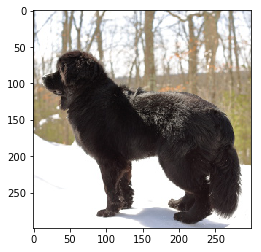

In [18]:
plt.imshow(0.5 * (X_test[0] + 1.0))

In [5]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
     percent = count * block_size * 100 // total_size
     sys.stdout.write("\rDownloading: {}%".format(percent))
     sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
     if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
          return
     os.makedirs(path) # removed exist_ok=True
     tgz_path = os.path.join(path, "inception_v3.tgz")
     urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
     inception_tgz = tarfile.open(tgz_path)
     inception_tgz.extractall(path=path)
     inception_tgz.close()
     os.remove(tgz_path)

In [6]:
#fetch_pretrained_inception_v3()

Form a list of the class names:

In [7]:
class_names = 'imagenet_class_names.txt'
with open(class_names, 'r') as f:
     cn = f.readlines()
cn = [c[10:].replace('\n', '').split(',') for c in cn]
cn = [['background']] + cn

import pandas as pd
df = pd.DataFrame(cn)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,background,None,None,None,None,None,None,None,None,None
1,tench,Tinca tinca,None,None,None,None,None,None,None,None
2,goldfish,Carassius auratus,None,None,None,None,None,None,None,None
3,great white shark,white shark,man-eater,man-eating shark,Carcharodon carcharias,None,None,None,None,None
4,tiger shark,Galeocerdo cuvieri,None,None,None,None,None,None,None,None


In [8]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [9]:
tf.reset_default_graph()

In [10]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
     logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points['Predictions']
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
with tf.Session() as sess:
     saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [12]:
with tf.Session() as sess:
     saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
     predictions_val = predictions.eval(feed_dict={X:X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


The variable predictions_val is of shape (5, 1001). It gives the probability that the image belongs to each class. Need to find the top 5 classes for each image.

In [13]:
most_likely_class_index = np.argmax(predictions_val, axis=1)
most_likely_class_index

array([257, 349, 334, 338, 295])

In [14]:
df.iloc[most_likely_class_index]

,0,1,2,3,4,5,6,7,8,9
257,Newfoundland,Newfoundland dog,None,None,None,None,None,None,None,None
349,ram,tup,None,None,None,None,None,None,None,None
334,hamster,None,None,None,None,None,None,None,None,None
338,beaver,None,None,None,None,None,None,None,None,None
295,brown bear,bruin,Ursus arctos,None,None,None,None,None,None,None


In [15]:
# consider np.partition
top5 = np.argsort(-predictions_val, axis=1)[:,:5]
top5

array([[257, 245, 256, 248, 206],
       [349, 350, 351, 105, 354],
       [334, 675, 331, 358, 332],
       [338, 685, 335, 361, 337],
       [295, 297, 296, 298, 388]])

In [16]:
for j in range(5):
     for i in range(5):
          print df.iloc[top5[j][i]][0], predictions_val[j][top5[j][i]]
     print "==-=="

Newfoundland 0.907862
Tibetan mastiff 0.0565172
Leonberg 0.00118222
Saint Bernard 0.000858788
flat-coated retriever 0.000704616
==-==
ram 0.474108
bighorn 0.149607
ibex 0.0692161
wallaby 0.0388407
gazelle 0.0193558
==-==
hamster 0.487816
mousetrap 0.172979
wood rabbit 0.0700672
mink 0.0137368
hare 0.0104962
==-==
beaver 0.963425
ocarina 0.000666861
porcupine 0.000582235
otter 0.000580089
marmot 0.000477408
==-==
brown bear 0.957922
ice bear 0.00403078
American black bear 0.00203949
sloth bear 0.000969583
lesser panda 0.000599052
==-==


In [17]:
msk = [any(df.iloc[i, :].str.contains('dog', na=False, case=False)) for i in range(df.shape[0])]
df[msk]

,0,1,2,3,4,5,6,7,8,9
154,Maltese dog,Maltese terrier,Maltese,None,None,None,None,None,None,None
201,Tibetan terrier,chrysanthemum dog,None,None,None,None,None,None,None,None
230,Old English sheepdog,bobtail,None,None,None,None,None,None,None,None
231,Shetland sheepdog,Shetland sheep dog,Shetland,None,None,None,None,None,None,None
236,German shepherd,German shepherd dog,German police dog,alsatian,None,None,None,None,None,None
239,Greater Swiss Mountain dog,None,None,None,None,None,None,None,None,None
240,Bernese mountain dog,None,None,None,None,None,None,None,None,None
246,French bulldog,None,None,None,None,None,None,None,None,None
249,Eskimo dog,husky,None,None,None,None,None,None,None,None
252,dalmatian,coach dog,carriage dog,None,None,None,None,None,None,None


The model has not been trained on donkeys or mice. It got all three others correct including getting the breed of dog exactly right.